## Download Dataset

In [1]:
import pandas as pd
data =  pd.read_csv('MasterDataset_WithWeatherAndEvent.csv')


C:\Users\ramir\AppData\Local\Temp\ipykernel_18624\106513335.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data =  pd.read_csv('MasterDataset_WithWeatherAndEvent.csv')


## Data Preparation

### Drop Unwanted Columns

In [2]:
data = data.drop(data.columns[[0,1,2]], axis=1)
data = data.drop(["date", "time"], axis=1)

### Deal with Missing Data

In [3]:
print(f"Total Number of rows: {len(data)}")
print(f"Total number of null values: {data.isnull().sum().sum()}")

print(100*(data.isnull().sum())/len(data))

Total Number of rows: 17218778
Total number of null values: 16765607
Duration                 0.000000
Start date               0.000000
End date                 0.000000
Start station number     0.000000
Start station            0.000000
End station number       0.000000
End station              0.000000
Member type              0.000000
temperature_2m           0.000000
relativehumidity_2m      0.000000
precipitation            0.000000
windspeed_10m            0.000000
holiday                 97.368158
isHoliday                0.000000
dtype: float64


In [4]:
print(len(data))

17218778


In [5]:
data['holiday'].fillna("Not a holiday", inplace=True)
data = data.dropna(how='any',axis=0)

In [6]:
print(len(data))

17218778


### Confer Appropriate DataTypes

In [7]:
data[['Start date', 'End date']] = data[['Start date', 'End date']].apply(pd.to_datetime)
data[['Start station', 'Start station number', 'End station','End station number', 'Member type', 'holiday']] = data[['Start station', 'Start station number', 'End station','End station number', 'Member type', 'holiday']].astype('category')
data[["Duration", "temperature_2m", "relativehumidity_2m", "precipitation", "windspeed_10m"]] = data[["Duration", "temperature_2m", "relativehumidity_2m", "precipitation", "windspeed_10m"]].astype('float')
data["isHoliday"] = data["isHoliday"].astype("boolean")

### Engineer Date and Time Features

In [8]:
data[["year", "month", "m_day", "hour"]] = data["Start date"].apply(lambda x: x.timetuple()[0:4]).tolist()
data["w_day"] = data["Start date"].apply(lambda x: x.weekday())

data["isWeekend"] = data["w_day"] > 4
data["isWeekend"] = data["isWeekend"].astype("boolean")

### Deal With Outliers

In [9]:
print(len(data))

17218778


In [10]:
cols = ["Duration"] #Numeric columns only
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
after_outlier = len(data)

In [11]:
print(len(data))

15937456


### Fix Miscellaneous Errors

In [12]:
data["Member type"] = data["Member type"].str.lower()
data = data[data["Start date"].dt.year < 2020]

In [13]:
print(len(data))

15937456


### Removing Rows with Discrepencies


In [14]:
print(len(data))

15937456


In [52]:
import warnings
warnings.filterwarnings('ignore')

non_negative = data['Duration'] >= 0

chunks = []
size = 1000

for element in range (0, len(data), size):
    item = element + size
    segment = data[element:item]
    chunk = segment[non_negative]
    chunks.append(chunk)

filtered = pd.concat(chunks)


In [16]:
print(len(data))

15937456


In [18]:
data.head()

Duration Start date   End date Start station number  \
2     468.0 2015-01-01 2015-01-01              31204.0   
3     348.0 2015-01-01 2015-01-01              31602.0   
4     980.0 2015-01-01 2015-01-01              31247.0   
5     932.0 2015-01-01 2015-01-01              31247.0   
6     387.0 2015-01-01 2015-01-01              31222.0   

               Start station End station number  \
2             20th & E St NW            31234.0   
3    Park Rd & Holmead Pl NW            31117.0   
4  Jefferson Dr & 14th St SW            31241.0   
5  Jefferson Dr & 14th St SW            31241.0   
6  New York Ave & 15th St NW            31202.0   

                     End station Member type  temperature_2m  \
2  20th & O St NW / Dupont South      member            -3.0   
3           15th & Euclid St  NW      member            -3.0   
4                  Thomas Circle      casual            -3.0   
5                  Thomas Circle      casual            -3.0   
6                 14th & R St NW      member            -3.0   

   relativehumidity_2m  precipitation  windspeed_10m         holiday  \
2                 65.0            0.0            8.0  New Year's Day   
3                 65.0            0.0            8.0  New Year's Day   
4                 65.0            0.0            8.0  New Year's Day   
5                 65.0            0.0            8.0  New Year's Day   
6                 65.0            0.0            8.0  New Year's Day   

   isHoliday  year  month  m_day  hour  w_day  isWeekend  
2       True  2015      1      1     0      3      False  
3       True  2015      1      1     0      3      False  
4       True  2015      1      1     0      3      False  
5       True  2015      1      1     0      3      False  
6       True  2015      1      1     0      3      False

------------------------------------------------

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Combined Data grouped by station.

In [20]:
groupedDepartures = data.groupby(['Start station', 'Start date']).agg(Departures = ('Start station number', 'count'),
                                                  Temperature = ('temperature_2m', 'mean'),
                                                  Humidity = ('relativehumidity_2m', 'mean'),
                                                  Precipitation = ('precipitation', 'mean'),
                                                  Windspeed = ('windspeed_10m', 'mean'),
                                                  isHoliday = ('isHoliday', 'max'),
                                                  Year = ('year', 'max'),
                                                  Month = ('month', 'max'),
                                                  m_day = ('m_day', 'max'),
                                                  hour = ('hour', 'max'),
                                                  isWeekend = ('isWeekend', 'max'))

groupedArrivals = data.groupby(['End station', 'Start date']).agg(Arrivals = ('End station number', 'count'),
                                                  Temperature = ('temperature_2m', 'mean'),
                                                  Humidity = ('relativehumidity_2m', 'mean'),
                                                  Precipitation = ('precipitation', 'mean'),
                                                  Windspeed = ('windspeed_10m', 'mean'),
                                                  isHoliday = ('isHoliday', 'max'),
                                                  Year = ('year', 'max'),
                                                  Month = ('month', 'max'),
                                                  m_day = ('m_day', 'max'),
                                                  hour = ('hour', 'max'),
                                                  isWeekend = ('isWeekend', 'max'))

groupedDepartures.update(groupedArrivals)
groupedDepartures['Arrivals'] = groupedArrivals['Arrivals']

groupedbyLocation = groupedDepartures[['Departures', 'Arrivals', 'Temperature', 'Humidity', 'Precipitation', 'Windspeed',
                   'isHoliday', 'Year', 'Month', 'm_day', 'hour', 'isWeekend']]

groupedbyLocation.reset_index(level=0, inplace=True)
groupedbyLocation = groupedbyLocation.groupby([pd.Grouper(freq='D')]).bfill().ffill()
groupedbyLocation = groupedbyLocation.reset_index().set_index(['Start station', 'Start date'])

groupedbyLocation['Total traffic'] = groupedbyLocation['Arrivals'] + groupedbyLocation['Departures']
groupedbyLocation['Net traffic'] = groupedbyLocation['Arrivals'] - groupedbyLocation['Departures']

groupedbyLocation.index.names = ['Station', 'Date']

In [21]:
groupedbyLocationDaily = groupedbyLocation.groupby(['Station', 'Year', 'Month',
                                                'm_day']).agg(Departures = ('Departures', 'sum'), 
                                                         Arrivals = ('Arrivals', 'sum'),
                                                         Temperature = ('Temperature', 'mean'),
                                                         Humidity = ('Humidity', 'mean'),
                                                         Precipitation = ('Precipitation', 'mean'),
                                                         Windspeed = ('Windspeed', 'mean'),
                                                         isHoliday = ('isHoliday', 'max'),
                                                         hour = ('hour', 'max'),
                                                         isWeekend = ('isWeekend', 'max'),
                                                         Total_traffic = ('Total traffic', 'sum'),
                                                         Net_traffic = ('Net traffic', 'sum'))

groupedbyLocationMonthly = groupedbyLocationDaily.groupby(['Station', 'Year', 'Month']).agg(Departures = ('Departures', 'sum'),
                                                                 Arrivals = ('Arrivals', 'sum'),
                                                                 Total_traffic = ('Total_traffic', 'sum'),
                                                                 Net_traffic = ('Net_traffic', 'sum'))


groupedbyLocationYearly = groupedbyLocationDaily.groupby(['Station', 'Year']).agg(Departures = ('Departures', 'sum'),
                                                                 Arrivals = ('Arrivals', 'sum'),
                                                                 Total_traffic = ('Total_traffic', 'sum'),
                                                                 Net_traffic = ('Net_traffic', 'sum'))

groupedbyLocationOverall = groupedbyLocationDaily.groupby(['Station']).agg(Departures = ('Departures', 'sum'),
                                                                 Arrivals = ('Arrivals', 'sum'),
                                                                 Total_traffic = ('Total_traffic', 'sum'),
                                                                 Net_traffic = ('Net_traffic', 'sum'))

groupedbyLocationWeekend = groupedbyLocation[groupedbyLocation['isWeekend'] == True]
groupedbyLocationHoliday = groupedbyLocation[groupedbyLocation['isHoliday'] == True]

In [22]:
groupedbyLocationDailyWeekend = groupedbyLocationWeekend.groupby(['Station', 'Year', 'Month',
                                                'm_day']).agg(Departures = ('Departures', 'sum'), 
                                                         Arrivals = ('Arrivals', 'sum'),
                                                         Temperature = ('Temperature', 'mean'),
                                                         Humidity = ('Humidity', 'mean'),
                                                         Precipitation = ('Precipitation', 'mean'),
                                                         Windspeed = ('Windspeed', 'mean'),
                                                         isHoliday = ('isHoliday', 'max'),
                                                         hour = ('hour', 'max'),
                                                         isWeekend = ('isWeekend', 'max'),
                                                         Total_traffic = ('Total traffic', 'sum'),
                                                         Net_traffic = ('Net traffic', 'sum'))

groupedbyLocationDailyHoliday = groupedbyLocationHoliday.groupby(['Station', 'Year', 'Month',
                                                'm_day']).agg(Departures = ('Departures', 'sum'), 
                                                         Arrivals = ('Arrivals', 'sum'),
                                                         Temperature = ('Temperature', 'mean'),
                                                         Humidity = ('Humidity', 'mean'),
                                                         Precipitation = ('Precipitation', 'mean'),
                                                         Windspeed = ('Windspeed', 'mean'),
                                                         isHoliday = ('isHoliday', 'max'),
                                                         hour = ('hour', 'max'),
                                                         isWeekend = ('isWeekend', 'max'),
                                                         Total_traffic = ('Total traffic', 'sum'),
                                                         Net_traffic = ('Net traffic', 'sum'))

In [23]:
groupedbyLocationOverallWeekend = groupedbyLocationDailyWeekend.groupby(['Station']).agg(Departures = ('Departures', 'sum'),
                                                                 Arrivals = ('Arrivals', 'sum'),
                                                                 Total_traffic = ('Total_traffic', 'sum'),
                                                                 Net_traffic = ('Net_traffic', 'sum'))

groupedbyLocationOverallHoliday = groupedbyLocationDailyHoliday.groupby(['Station']).agg(Departures = ('Departures', 'sum'),
                                                                 Arrivals = ('Arrivals', 'sum'),
                                                                 Total_traffic = ('Total_traffic', 'sum'),
                                                                 Net_traffic = ('Net_traffic', 'sum'))


In [24]:
overallIndex = groupedbyLocationOverall.sort_values(by = "Departures", ascending = False)[:15].index
groupedbyLocationOverall.loc[overallIndex]



Departures  Arrivals  \
Station                                                                    
Columbus Circle / Union Station                         320991  335898.0   
Massachusetts Ave & Dupont Circle NW                    210504  241045.0   
Lincoln Memorial                                        208842  221079.0   
15th & P St NW                                          196476  211922.0   
Jefferson Dr & 14th St SW                               180647  190500.0   
New Hampshire Ave & T St NW                             165046  157447.0   
Thomas Circle                                           157911  146035.0   
14th & V St NW                                          153663  172352.0   
Eastern Market Metro / Pennsylvania Ave & 7th S...      149992  147534.0   
Jefferson Memorial                                      148351  150777.0   
1st & M St NE                                           145279  149721.0   
5th & K St NW                                           134676  142199.0   
17th & Corcoran St NW                                   128554  132172.0   
14th & Rhode Island Ave NW                              127212  135048.0   
8th & H St NW                                           124083  144665.0   

                                                    Total_traffic  Net_traffic  
Station                                                                         
Columbus Circle / Union Station                          656889.0      14907.0  
Massachusetts Ave & Dupont Circle NW                     451549.0      30541.0  
Lincoln Memorial                                         429921.0      12237.0  
15th & P St NW                                           408398.0      15446.0  
Jefferson Dr & 14th St SW                                371147.0       9853.0  
New Hampshire Ave & T St NW                              322493.0      -7599.0  
Thomas Circle                                            303946.0     -11876.0  
14th & V St NW                                           326015.0      18689.0  
Eastern Market Metro / Pennsylvania Ave & 7th S...       297526.0      -2458.0  
Jefferson Memorial                                       299128.0       2426.0  
1st & M St NE                                            295000.0       4442.0  
5th & K St NW                                            276875.0       7523.0  
17th & Corcoran St NW                                    260726.0       3618.0  
14th & Rhode Island Ave NW                               262260.0       7836.0  
8th & H St NW                                            268748.0      20582.0

In [25]:
holidayIndex = groupedbyLocationOverallHoliday.sort_values(by = "Departures", ascending = False)[:15].index
groupedbyLocationOverallHoliday.loc[holidayIndex]


Departures  Arrivals  \
Station                                                                    
Lincoln Memorial                                          7589    8043.0   
Jefferson Dr & 14th St SW                                 6422    6439.0   
15th & P St NW                                            5414    5951.0   
Jefferson Memorial                                        5294    5433.0   
Columbus Circle / Union Station                           5215    5328.0   
Massachusetts Ave & Dupont Circle NW                      5143    5931.0   
New Hampshire Ave & T St NW                               4307    4236.0   
14th & V St NW                                            4149    4718.0   
Smithsonian-National Mall / Jefferson Dr & 12th...        3749    4062.0   
5th & K St NW                                             3692    3959.0   
Eastern Market Metro / Pennsylvania Ave & 7th S...        3655    3680.0   
14th & R St NW                                            3620    3993.0   
14th & Rhode Island Ave NW                                3611    3875.0   
Thomas Circle                                             3605    3396.0   
17th & Corcoran St NW                                     3513    3700.0   

                                                    Total_traffic  Net_traffic  
Station                                                                         
Lincoln Memorial                                          15632.0        454.0  
Jefferson Dr & 14th St SW                                 12861.0         17.0  
15th & P St NW                                            11365.0        537.0  
Jefferson Memorial                                        10727.0        139.0  
Columbus Circle / Union Station                           10543.0        113.0  
Massachusetts Ave & Dupont Circle NW                      11074.0        788.0  
New Hampshire Ave & T St NW                                8543.0        -71.0  
14th & V St NW                                             8867.0        569.0  
Smithsonian-National Mall / Jefferson Dr & 12th...         7811.0        313.0  
5th & K St NW                                              7651.0        267.0  
Eastern Market Metro / Pennsylvania Ave & 7th S...         7335.0         25.0  
14th & R St NW                                             7613.0        373.0  
14th & Rhode Island Ave NW                                 7486.0        264.0  
Thomas Circle                                              7001.0       -209.0  
17th & Corcoran St NW                                      7213.0        187.0

In [26]:
weekendIndex = groupedbyLocationOverallWeekend.sort_values(by = "Departures", ascending = False)[:15].index
groupedbyLocationOverallWeekend.loc[weekendIndex]



Departures  Arrivals  \
Station                                                                    
Lincoln Memorial                                         83466   88759.0   
Jefferson Dr & 14th St SW                                67251   71073.0   
15th & P St NW                                           55817   60751.0   
Jefferson Memorial                                       55244   56018.0   
Massachusetts Ave & Dupont Circle NW                     54719   68208.0   
14th & V St NW                                           48494   54172.0   
New Hampshire Ave & T St NW                              47239   44925.0   
Henry Bacon Dr & Lincoln Memorial Circle NW              41301   44304.0   
Columbus Circle / Union Station                          41232   42874.0   
14th & R St NW                                           40491   44351.0   
Eastern Market Metro / Pennsylvania Ave & 7th S...       40352   43075.0   
Smithsonian-National Mall / Jefferson Dr & 12th...       39729   42728.0   
17th & Corcoran St NW                                    38791   40193.0   
14th & Rhode Island Ave NW                               38085   41168.0   
5th & K St NW                                            37090   39724.0   

                                                    Total_traffic  Net_traffic  
Station                                                                         
Lincoln Memorial                                         172225.0       5293.0  
Jefferson Dr & 14th St SW                                138324.0       3822.0  
15th & P St NW                                           116568.0       4934.0  
Jefferson Memorial                                       111262.0        774.0  
Massachusetts Ave & Dupont Circle NW                     122927.0      13489.0  
14th & V St NW                                           102666.0       5678.0  
New Hampshire Ave & T St NW                               92164.0      -2314.0  
Henry Bacon Dr & Lincoln Memorial Circle NW               85605.0       3003.0  
Columbus Circle / Union Station                           84106.0       1642.0  
14th & R St NW                                            84842.0       3860.0  
Eastern Market Metro / Pennsylvania Ave & 7th S...        83427.0       2723.0  
Smithsonian-National Mall / Jefferson Dr & 12th...        82457.0       2999.0  
17th & Corcoran St NW                                     78984.0       1402.0  
14th & Rhode Island Ave NW                                79253.0       3083.0  
5th & K St NW                                             76814.0       2634.0

In [27]:
combinedOverall = groupedbyLocationOverall.copy()

In [28]:
combinedOverall = combinedOverall.merge(groupedbyLocationOverallHoliday['Departures'], on="Station").rename(columns={'Departures_x': 'Departures Overall',
                                                                                                   'Departures_y': 'Departures Holidays'})

combinedOverall = combinedOverall.merge(groupedbyLocationOverallWeekend['Departures'], on="Station").rename(columns={'Departures': 'Departures Weekend'})



<Axes: xlabel='Station'>

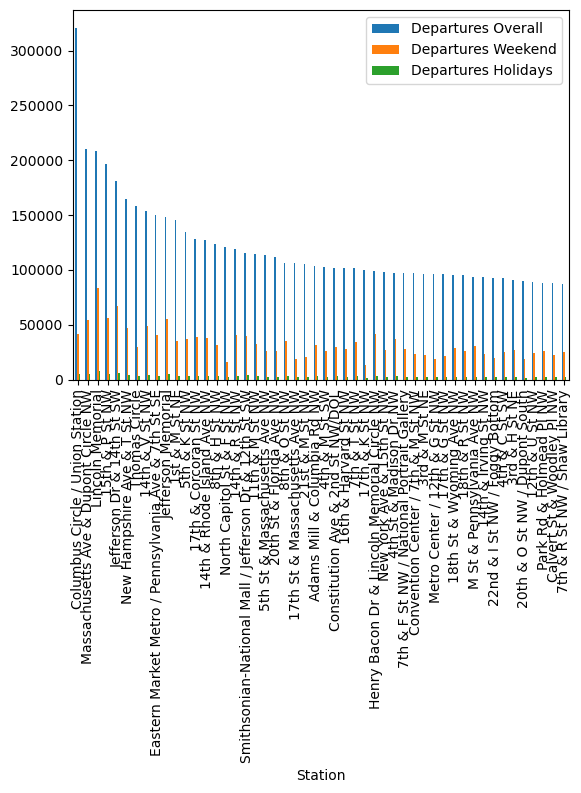

In [29]:
combinedOverall.sort_values(by="Departures Overall", ascending = False)[['Departures Overall', 'Departures Weekend', 'Departures Holidays']][:50].plot.bar()





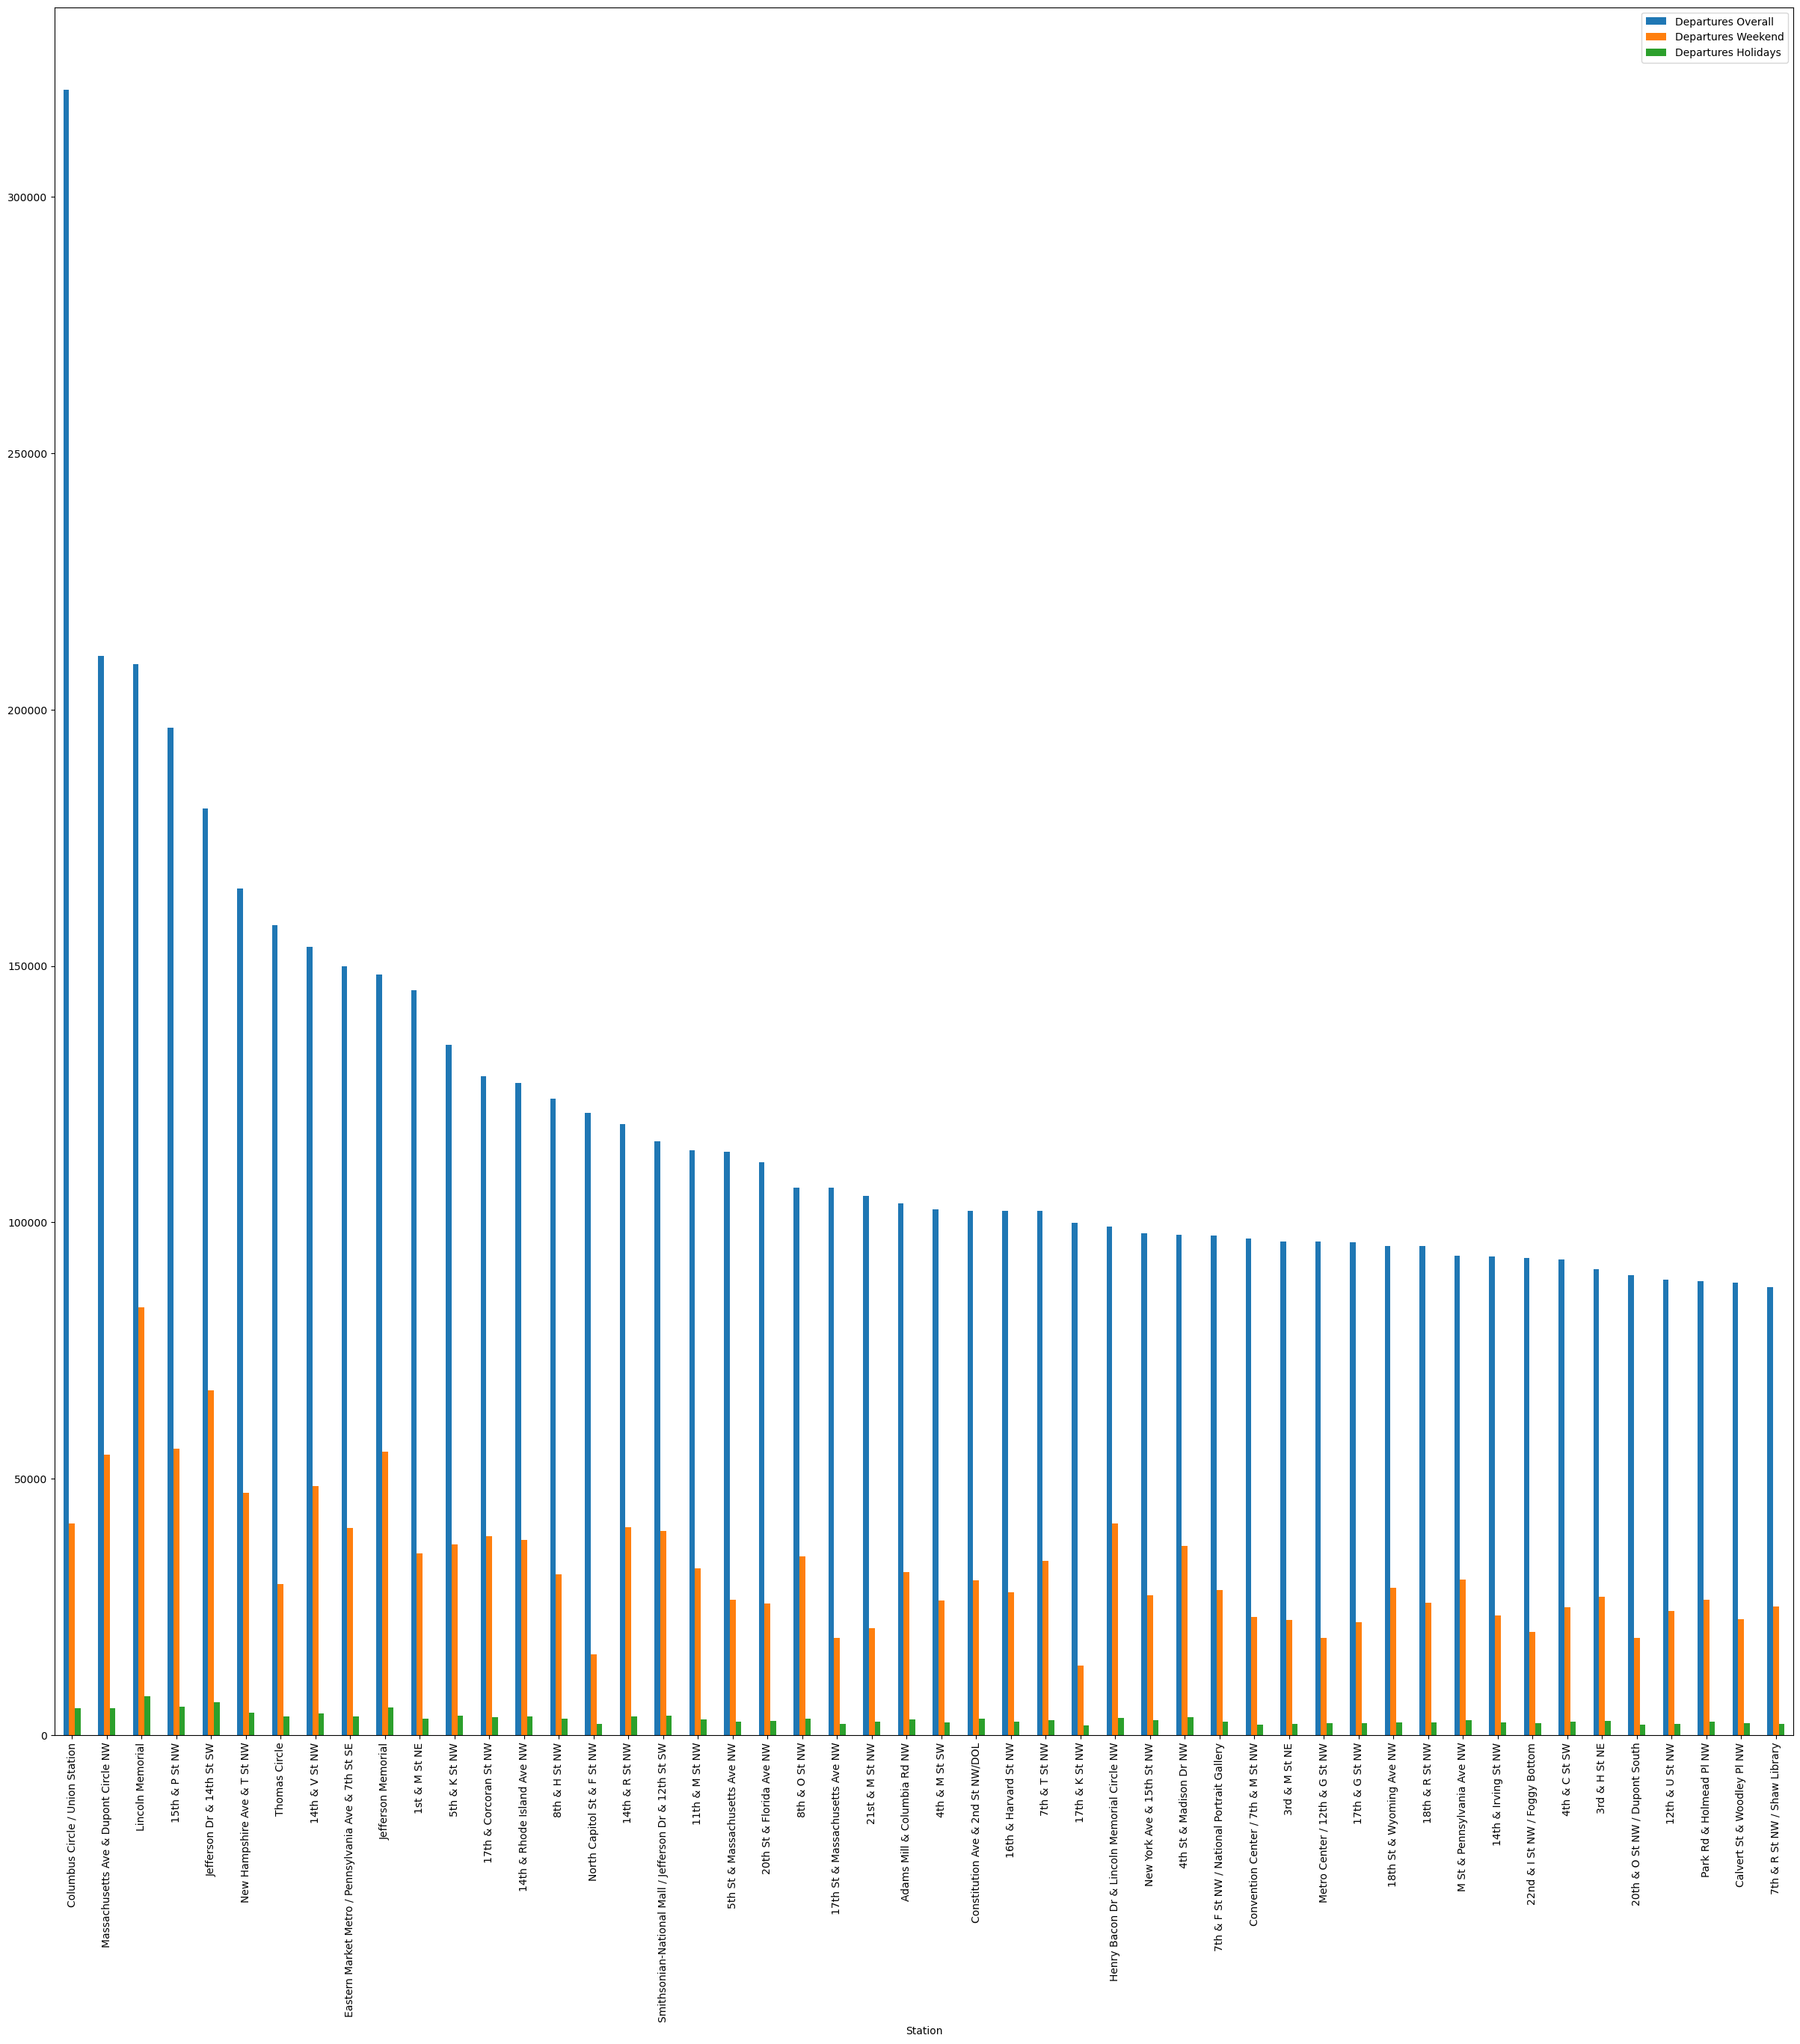

In [30]:
ax1 = combinedOverall.sort_values(by="Departures Overall", ascending = False)[['Departures Overall', 'Departures Weekend', 'Departures Holidays']][:50].plot.bar(figsize=(30,30))

fig1 = ax1.get_figure()

# fig1.savefig('all.png')

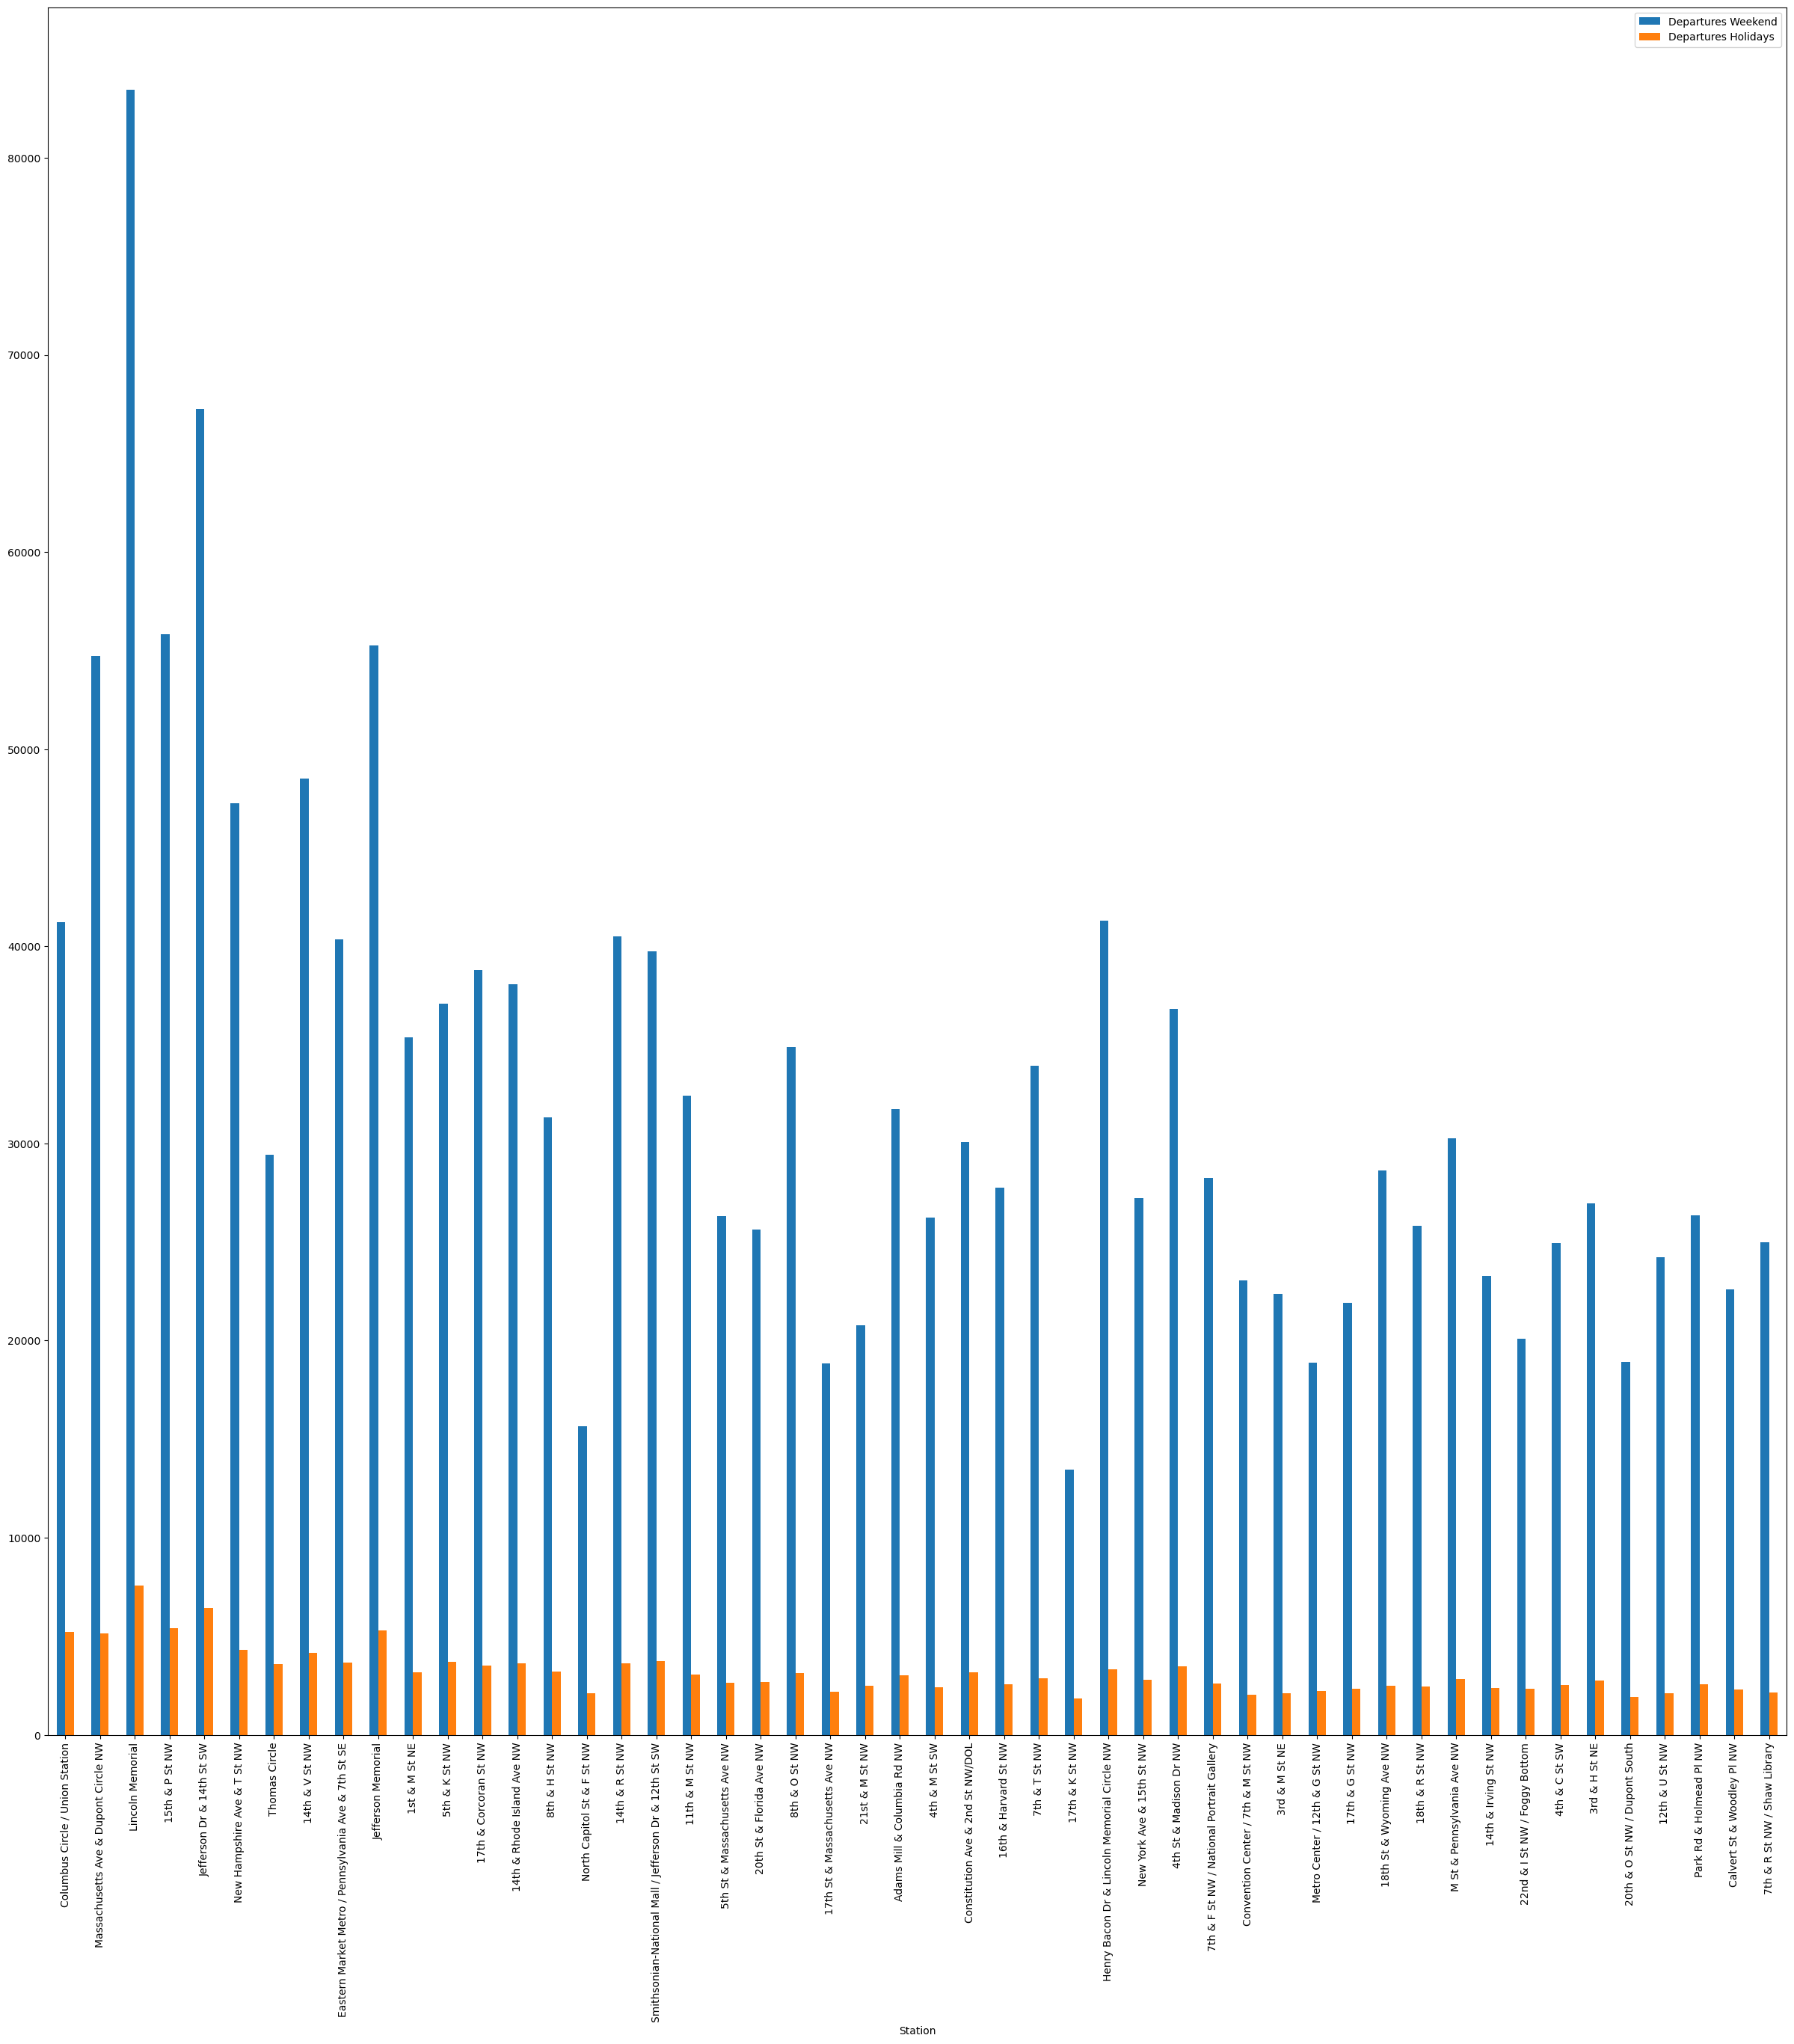

In [31]:
ax2 = combinedOverall.sort_values(by="Departures Overall", ascending = False)[['Departures Weekend', 'Departures Holidays']][:50].plot.bar(figsize=(30,30))

fig2 = ax2.get_figure()

# fig2.savefig('part.png')


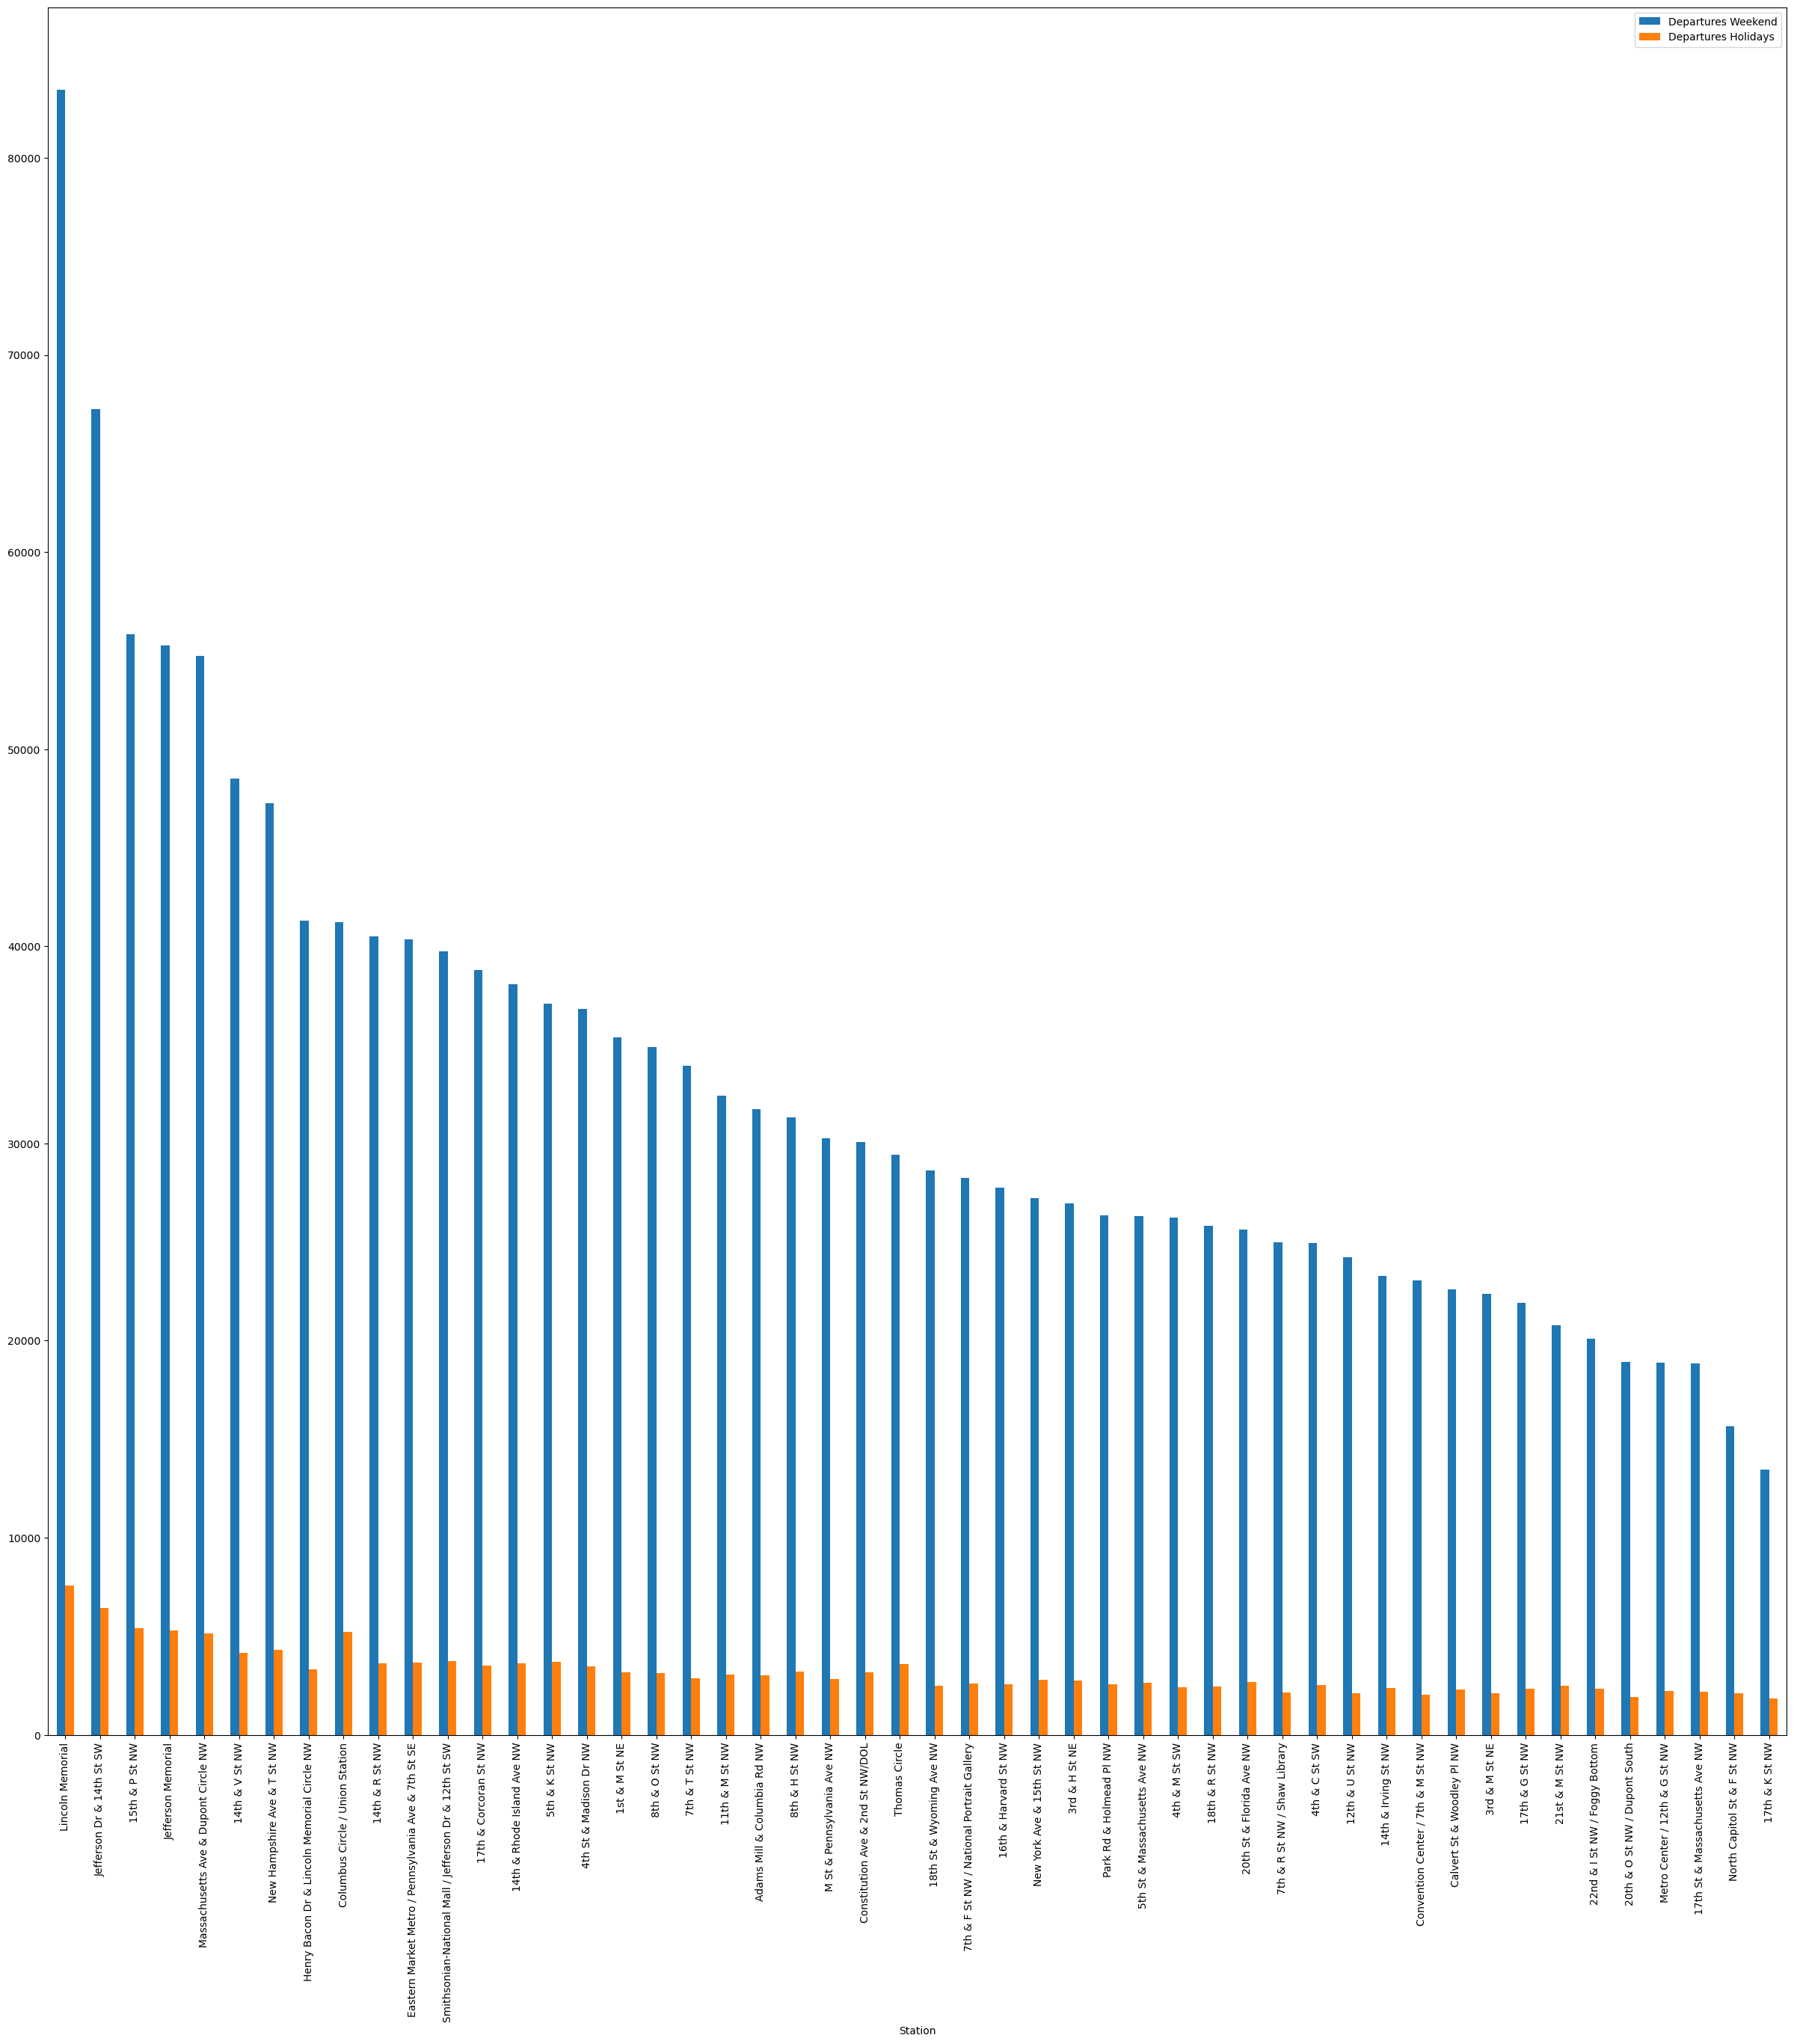

In [32]:
ax3 = combinedOverall.sort_values(by="Departures Overall", ascending = False)[:50].sort_values(by="Departures Weekend", ascending= False)[['Departures Weekend', 'Departures Holidays']].plot.bar(figsize=(30,30))

fig3 = ax3.get_figure()

# fig3.savefig('part sorted.png')




<Axes: xlabel='Station'>

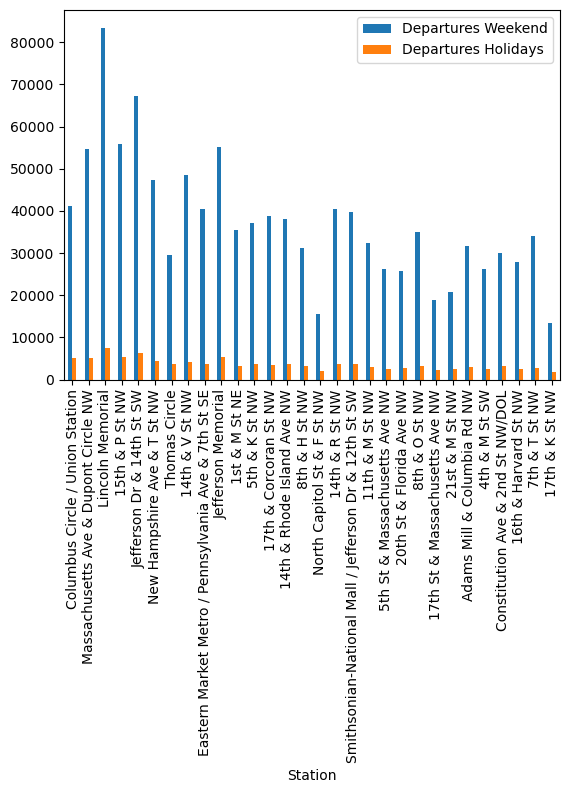

In [33]:
combinedOverall.sort_values(by="Departures Overall", ascending = False)[['Departures Weekend', 'Departures Holidays']][:30].plot.bar()


In [34]:
combinedOverall.sort_values(by="Departures Overall", ascending = False)[['Departures Overall', 'Departures Weekend', 'Departures Holidays']][:50]


Departures Overall  \
Station                                                                  
Columbus Circle / Union Station                                 320991   
Massachusetts Ave & Dupont Circle NW                            210504   
Lincoln Memorial                                                208842   
15th & P St NW                                                  196476   
Jefferson Dr & 14th St SW                                       180647   
New Hampshire Ave & T St NW                                     165046   
Thomas Circle                                                   157911   
14th & V St NW                                                  153663   
Eastern Market Metro / Pennsylvania Ave & 7th S...              149992   
Jefferson Memorial                                              148351   
1st & M St NE                                                   145279   
5th & K St NW                                                   134676   
17th & Corcoran St NW                                           128554   
14th & Rhode Island Ave NW                                      127212   
8th & H St NW                                                   124083   
North Capitol St & F St NW                                      121324   
14th & R St NW                                                  119195   
Smithsonian-National Mall / Jefferson Dr & 12th...              115816   
11th & M St NW                                                  114093   
5th St & Massachusetts Ave NW                                   113711   
20th St & Florida Ave NW                                        111722   
8th & O St NW                                                   106756   
17th St & Massachusetts Ave NW                                  106733   
21st & M St NW                                                  105170   
Adams Mill & Columbia Rd NW                                     103739   
4th & M St SW                                                   102540   
Constitution Ave & 2nd St NW/DOL                                102221   
16th & Harvard St NW                                            102166   
7th & T St NW                                                   102159   
17th & K St NW                                                   99857   
Henry Bacon Dr & Lincoln Memorial Circle NW                      99215   
New York Ave & 15th St NW                                        97773   
4th St & Madison Dr NW                                           97593   
7th & F St NW / National Portrait Gallery                        97446   
Convention Center / 7th & M St NW                                96864   
3rd & M St NE                                                    96251   
Metro Center / 12th & G St NW                                    96188   
17th & G St NW                                                   96131   
18th St & Wyoming Ave NW                                         95414   
18th & R St NW                                                   95321   
M St & Pennsylvania Ave NW                                       93502   
14th & Irving St NW                                              93285   
22nd & I St NW / Foggy Bottom                                    92996   
4th & C St SW                                                    92757   
3rd & H St NE                                                    90882   
20th & O St NW / Dupont South                                    89731   
12th & U St NW                                                   88840   
Park Rd & Holmead Pl NW                                          88435   
Calvert St & Woodley Pl NW                                       88195   
7th & R St NW / Shaw Library                                     87330   

                                                    Departures Weekend  \
Station                                                                  
Columbus Circle / Union Station                        

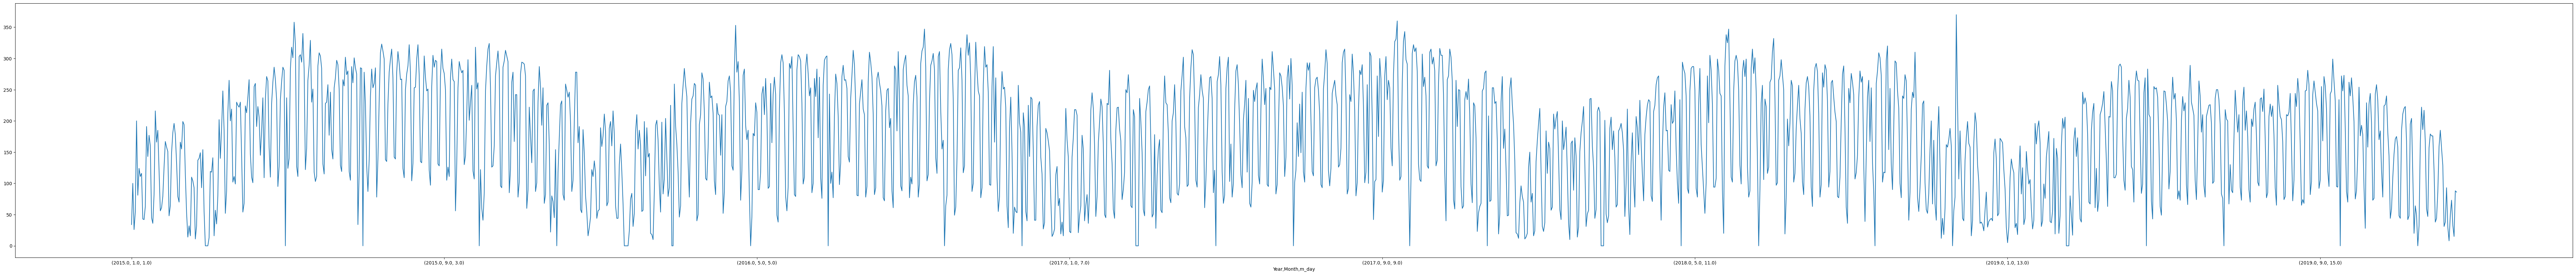

In [35]:
ax4 = groupedbyLocationDaily.loc['Columbus Circle / Union Station']['Departures'].plot(figsize=(100,10))

fig4 = ax4.get_figure()

# fig4.savefig('Columbus Circle Union Station.png')

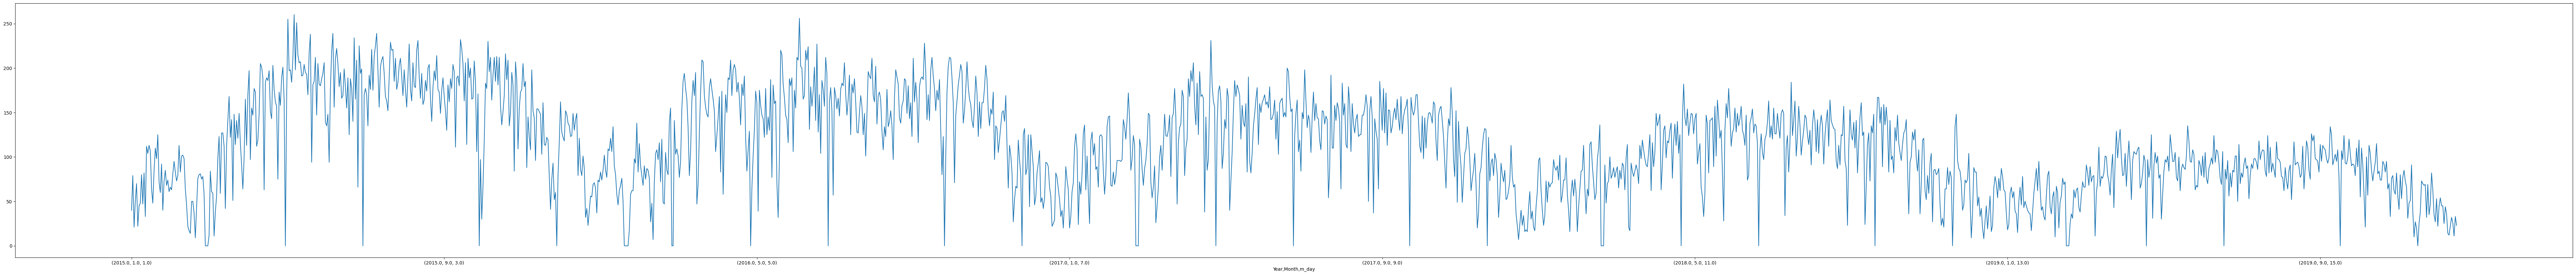

In [36]:
ax5 = groupedbyLocationDaily.loc['Massachusetts Ave & Dupont Circle NW']['Departures'].plot(figsize=(100,10))

fig5 = ax5.get_figure()

# fig5.savefig('Massachusetts Ave & Dupont Circle NW.png')

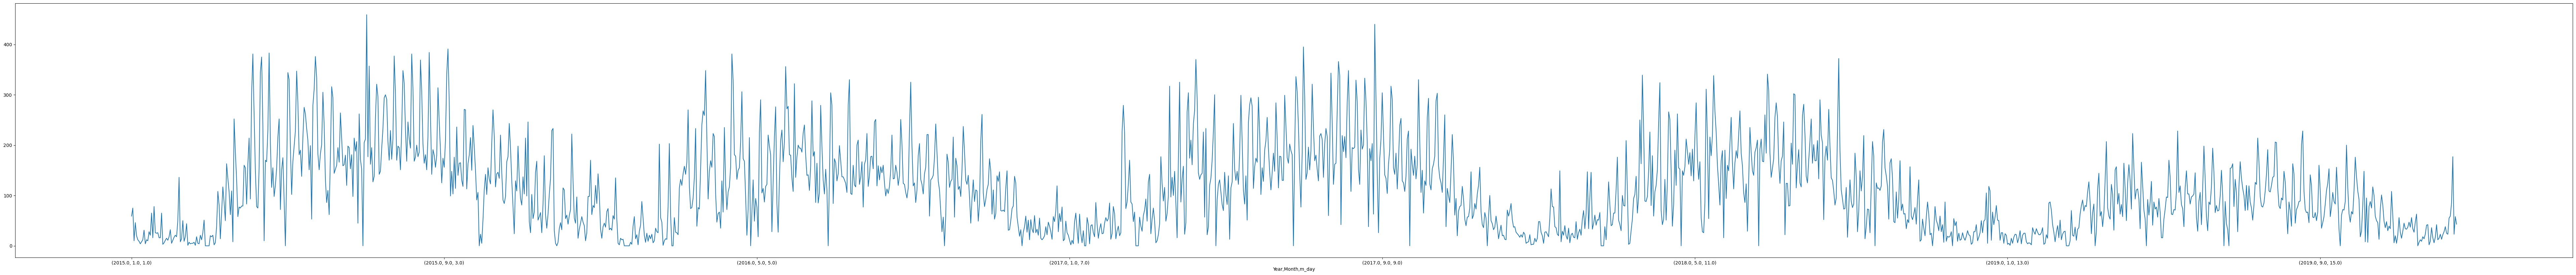

In [37]:
ax6 = groupedbyLocationDaily.loc['Lincoln Memorial']['Departures'].plot(figsize=(100,10))

fig6 = ax6.get_figure()

# fig6.savefig('Lincoln Memorial.png')

In [38]:
groupedbyLocationDaily = groupedbyLocation.groupby(['Station', 'Year', 'Month',
                                                'm_day']).agg(Departures = ('Departures', 'sum'), 
                                                         Arrivals = ('Arrivals', 'sum'),
                                                         Temperature = ('Temperature', 'mean'),
                                                         Humidity = ('Humidity', 'mean'),
                                                         Precipitation = ('Precipitation', 'mean'),
                                                         Windspeed = ('Windspeed', 'mean'),
                                                         isHoliday = ('isHoliday', 'max'),
                                                         hour = ('hour', 'max'),
                                                         isWeekend = ('isWeekend', 'max'))




In [39]:
groupedbyLocationDaily['Total traffic'] = groupedbyLocationDaily['Arrivals'] + groupedbyLocationDaily['Departures']

In [40]:
groupedbyLocationDaily['Net traffic'] = groupedbyLocationDaily['Arrivals'] -groupedbyLocationDaily['Departures'] 

In [41]:
overallIndex = groupedbyLocationOverall.sort_values(by = "Departures", ascending = False)[:15].index

In [46]:
testIndex = groupedbyLocationOverall.sort_values(by = "Departures", ascending = False)[:15].index

In [47]:
testIndex.values

['Columbus Circle / Union Station', 'Massachusetts Ave & Dupont Circle NW', 'Lincoln Memorial', '15th & P St NW', 'Jefferson Dr & 14th St SW', ..., '1st & M St NE', '5th & K St NW', '17th & Corcoran St NW', '14th & Rhode Island Ave NW', '8th & H St NW']
Length: 15
Categories (667, object): ['10th & E St NW', '10th & Florida Ave NW', '10th & G St NW', '10th & K St NW', ..., 'Woodglen Dr & Executive Blvd', 'Woodley Park Metro / Calvert St & Connecticut..., 'Woodmont Ave & Strathmore St', 'Yuma St & Tenley Circle NW']

In [48]:
groupedbyLocationOverall.loc[testIndex]

Departures  Arrivals  \
Station                                                                    
Columbus Circle / Union Station                         320991  335898.0   
Massachusetts Ave & Dupont Circle NW                    210504  241045.0   
Lincoln Memorial                                        208842  221079.0   
15th & P St NW                                          196476  211922.0   
Jefferson Dr & 14th St SW                               180647  190500.0   
New Hampshire Ave & T St NW                             165046  157447.0   
Thomas Circle                                           157911  146035.0   
14th & V St NW                                          153663  172352.0   
Eastern Market Metro / Pennsylvania Ave & 7th S...      149992  147534.0   
Jefferson Memorial                                      148351  150777.0   
1st & M St NE                                           145279  149721.0   
5th & K St NW                                           134676  142199.0   
17th & Corcoran St NW                                   128554  132172.0   
14th & Rhode Island Ave NW                              127212  135048.0   
8th & H St NW                                           124083  144665.0   

                                                    Total_traffic  Net_traffic  
Station                                                                         
Columbus Circle / Union Station                          656889.0      14907.0  
Massachusetts Ave & Dupont Circle NW                     451549.0      30541.0  
Lincoln Memorial                                         429921.0      12237.0  
15th & P St NW                                           408398.0      15446.0  
Jefferson Dr & 14th St SW                                371147.0       9853.0  
New Hampshire Ave & T St NW                              322493.0      -7599.0  
Thomas Circle                                            303946.0     -11876.0  
14th & V St NW                                           326015.0      18689.0  
Eastern Market Metro / Pennsylvania Ave & 7th S...       297526.0      -2458.0  
Jefferson Memorial                                       299128.0       2426.0  
1st & M St NE                                            295000.0       4442.0  
5th & K St NW                                            276875.0       7523.0  
17th & Corcoran St NW                                    260726.0       3618.0  
14th & Rhode Island Ave NW                               262260.0       7836.0  
8th & H St NW                                            268748.0      20582.0